In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import sys
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import end_to_end_profiles as e2e_profs
import numpy as np
from optimizer import BruteForceOptimizer, GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import logging
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [31]:
dag = profiler.get_logical_pipeline("pipeline_one")
with open(os.path.abspath("../results_python_benchmarker/e2e_profs/systemx/image_driver_1/500ms"
                          "/incep_1-logreg_1-ksvm_1-resnet_1-171221_091209.json")) as f:
    sample_run = json.load(f)
scale_factors = profiler.get_node_scale_factors(sample_run, dag.reference_node)
node_configs = profiler.get_node_configs_from_experiment(sample_run)
profs = snp.load_single_node_profiles(models=[n for n in node_configs])
profs["tf-kernel-svm"]

,num_cpus_per_replica,thru_stage_mean_throughput_qps,thru_stage_std_throughput_qps,latency_stage_mean_throughput_qps,latency_stage_std_throughput_qps,p99_latency,mean_batch_size,mean_queue_size,cost,fname,cloud,gpu_type
0,1,144.020871,1.678668,139.771721,0.732253,0.015278,2.0,0.0,0.0665,under_over-cpp-aws-results-k80-tf-kernel-svm-b...,aws,none
1,1,812.076735,2.485683,775.310715,3.179206,0.021713,16.0,0.0,0.0665,under_over-cpp-aws-results-k80-tf-kernel-svm-b...,aws,none
2,2,539.531223,18.000642,546.127878,54.055272,0.070105,24.0,0.0,0.0780,under_over-cpp-gcp-results-None-tf-kernel-svm-...,gcp,none
3,2,112.270079,23.753492,177.124572,12.637787,0.033034,4.0,0.0,0.0780,under_over-cpp-gcp-results-None-tf-kernel-svm-...,gcp,none
4,2,56.804736,0.495333,54.600852,0.228470,0.021341,1.0,0.0,0.0780,under_over-cpp-gcp-results-None-tf-kernel-svm-...,gcp,none
5,2,674.470043,50.229425,730.666014,84.064606,0.069167,32.0,0.0,0.0780,under_over-cpp-gcp-results-None-tf-kernel-svm-...,gcp,none
6,1,662.210627,11.681858,644.128682,1.427818,0.019306,12.0,0.0,0.0665,under_over-cpp-aws-results-k80-tf-kernel-svm-b...,aws,none
7,1,277.210687,3.860657,270.237800,0.648386,0.015690,4.0,0.0,0.0665,under_over-cpp-aws-results-k80-tf-kernel-svm-b...,aws,none
8,1,506.854646,0.944592,484.090712,2.187331,0.017416,8.0,0.0,0.0665,under_over-cpp-aws-results-k80-tf-kernel-svm-b...,aws,none
9,2,271.316559,49.398474,220.398136,48.294614,0.069766,8.0,0.0,0.0780,under_over-cpp-gcp-results-None-tf-kernel-svm-...,gcp,none


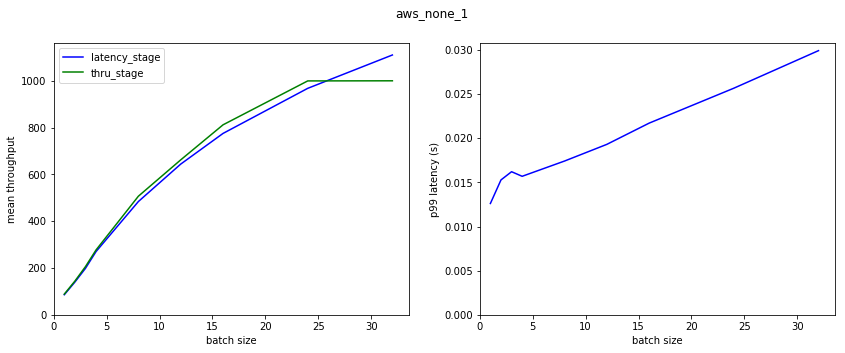

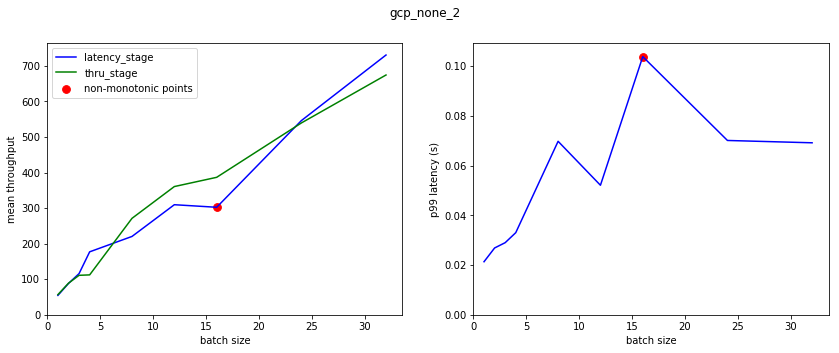

In [33]:
p = profiler.NodeProfile("tf-kernel-svm", profs["tf-kernel-svm"], "latency_stage")
p.plot_profile()

In [19]:
node_profs = {}
for name in node_configs:
    if name in ["tf-log-reg", "tf-kernel-svm"]:
        node_profs[name] = profiler.NodeProfile(name, profs[name], "latency_stage")
    else:
        node_profs[name] = profiler.NodeProfile(name, profs[name], "thru_stage")


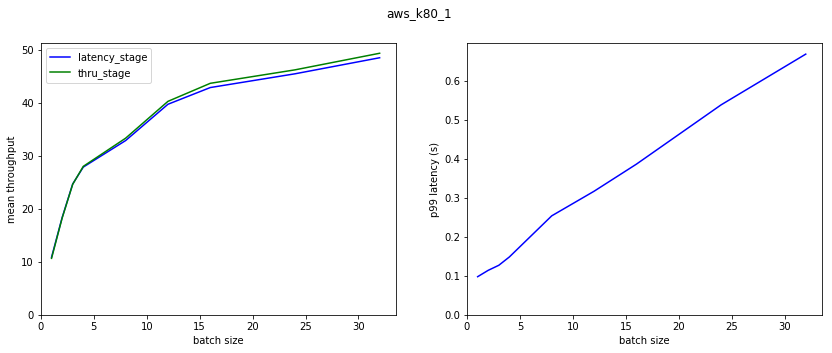

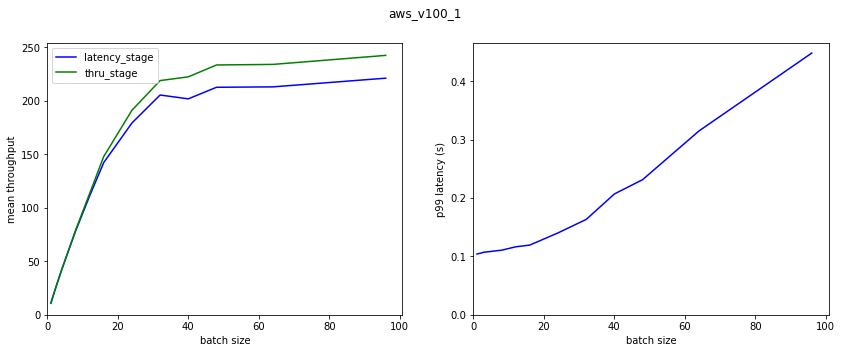

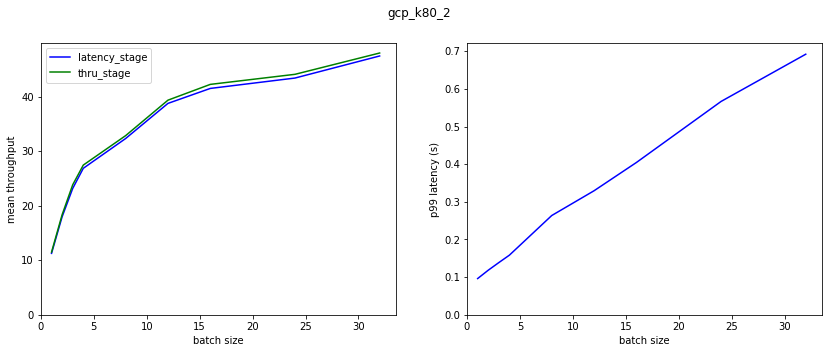

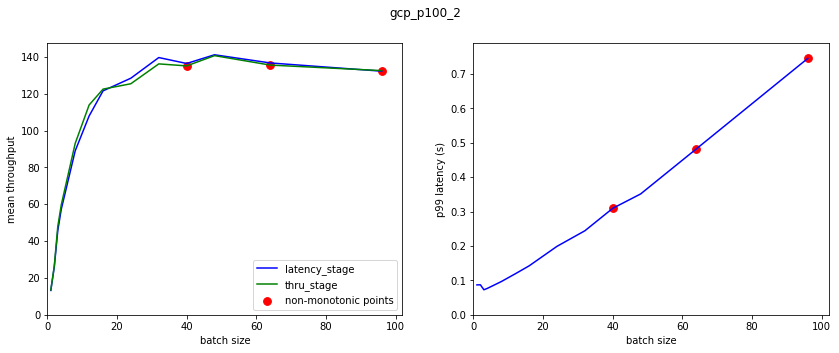

In [22]:
node_profs["tf-resnet-feats"].plot_profile()

In [11]:
dag = profiler.get_logical_pipeline("pipeline_one")
with open(os.path.abspath("../results_python_benchmarker/e2e_profs/systemx/image_driver_1/500ms/incep_1-logreg_1-ksvm_1-resnet_1-171221_091209.json")) as f:
    sample_run = json.load(f)
scale_factors = profiler.get_node_scale_factors(sample_run, dag.reference_node)
node_configs = profiler.get_node_configs_from_experiment(sample_run)
node_profs = {}
for name, _ in node_configs.items():
    if name in ["tf-log-reg", "tf-kernel-svm"]:
        node_profs[name] = profiler.NodeProfile(name, profs[name], "latency_stage")
    else:
        node_profs[name] = profiler.NodeProfile(name, profs[name], "thru_stage")


# node_profs = {name : profiler.NodeProfile(name, profs[name]) for name, _ in node_configs.items()}

KeyError: 'inception'

In [10]:
node_profs['tf-kernel-svm']

[NodeConfig(tf-kernel-svm, 1, none, 2.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 16.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 12.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 4.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 8.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 1.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 24.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 3.0, 1, aws),
 NodeConfig(tf-kernel-svm, 1, none, 32.0, 1, aws)]

In [17]:
with open("../debugging/arrival_deltas_ms.timestamp", "r") as f:
    arrival_deltas = np.array([float(l.strip()) for l in f]).flatten()
    print(np.min(arrival_deltas))
    arrival_deltas = np.clip(arrival_deltas, a_min=0.047, a_max=None)
    print(np.min(arrival_deltas))

    arrival_history = np.cumsum(arrival_deltas)

0.000186616787687
0.047


In [19]:
with open("../results_cpp_benchmarker/e2e_results/image_driver_1/cpp-aws-p2-1-inception-1-resnet-3-ksvm-1-logreg-180324_170634.json", "r") as f:
    results = json.load(f)
    resnet_lineage = results["throughput_results"]["lineage"]["tf-resnet-feats"][:40000]
    send_times = [l["driver::send"] for l in resnet_lineage]
    send_times = np.diff(send_times) / 1000.0

with open("../debugging/measured_arrival_deltas_ms.timestamp", "w") as f:
    for s in send_times:
        f.write("{}\n".format(s))

In [15]:
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "aws"
initial_config = {"inception": profiler.NodeConfig(name="inception",
                                                      num_cpus=1,
                                                      gpu_type="v100",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-resnet-feats": profiler.NodeConfig(name="tf-resnet-feats",
                                                      num_cpus=1,
                                                      gpu_type="v100",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-log-reg": profiler.NodeConfig(name="tf-log-reg",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-kernel-svm": profiler.NodeConfig(name="tf-kernel-svm",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
opt.select_optimal_config(cloud, 0.5, 5.5, initial_config, send_times, optimize_what="throughput", use_netcalc=True)

18-03-28:11:18:37 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:18:59 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:19:23 INFO     [optimizer.py:337] Upgrading bottleneck node tf-resnet-feats to NodeConfig(tf-resnet-feats, 1, v100, 2.0, 1, aws)
18-03-28:11:19:23 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:19:53 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:20:17 INFO     [optimizer.py:337] Upgrading bottleneck node tf-resnet-feats to NodeConfig(tf-resnet-feats, 1, v100, 3.0, 1, aws)
18-03-28:11:20:17 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:20:44 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:21:13 INFO     [optimizer.py:337] Upgrading bottleneck node inception to NodeConfig(inception, 1, v100, 2.0, 1, aws)
18-03-28:11:21:13 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:21:36 INFO     [optimizer.py:143] Getting max queue
18-03-28:11:21:59 INFO     [optimizer.py:337] Upgrading bottleneck node tf-re

({'inception': NodeConfig(inception, 1, v100, 24.0, 1, aws),
  'tf-kernel-svm': NodeConfig(tf-kernel-svm, 1, none, 4.0, 1, aws),
  'tf-log-reg': NodeConfig(tf-log-reg, 1, none, 1, 1, aws),
  'tf-resnet-feats': NodeConfig(tf-resnet-feats, 1, v100, 96.0, 1, aws)},
 {'cost': 5.3219999999999992,
  'latency': 0.46440257,
  'throughput': 248.0178965950795},
 0.47088060739143689)

In [ ]:
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "aws"
initial_config = {"inception": profiler.NodeConfig(name="inception",
                                                      num_cpus=1,
                                                      gpu_type="v100",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-resnet-feats": profiler.NodeConfig(name="tf-resnet-feats",
                                                      num_cpus=1,
                                                      gpu_type="v100",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-log-reg": profiler.NodeConfig(name="tf-log-reg",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-kernel-svm": profiler.NodeConfig(name="tf-kernel-svm",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
opt.select_optimal_config(cloud, 0.3, 5.5, initial_config)

In [ ]:
node_profs["res152"].plot_profile()

In [ ]:
for n, p in node_profs.items():
    p.check_monotonicity()
    r = p.plot_profile()
    break

In [ ]:
b = [True, True, False]
for i, p in enumerate(b):
    print(i,p)

In [ ]:
p = node_profs["alexnet"]
p.profile.iloc[7]["mean_batch_size"]

In [ ]:
for bundle, _ in r:
    print("-".join([str(b) for b in bundle]))

In [ ]:
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "gcp"
initial_config = {"tf": profiler.NodeConfig(name="alexnet",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "res50": profiler.NodeConfig(name="res50",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                          batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "res152": profiler.NodeConfig(name="res152",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
opt.select_optimal_config(cloud, 0.7, 50, initial_config)

In [ ]:
import itertools
def brute_force_optimizer(dag, scale_factors, node_profs, cost_constraint, latency_constraint):
    """
        This doesn't loo
    """
    all_node_configs = [node_profs[node].enumerate_configs(max_replication_factor=3) for node in dag.nodes()]     
    all_pipeline_configs = itertools.product(*all_node_configs)
    num_valid_configs = 0
    best_config = None
    best_config_perf = None
    cur_index = 0
    for p_config in all_pipeline_configs:
        cur_index += 1
        if cur_index % 500 == 0:
            print("Processed {}".format(cur_index))
        cur_node_configs = {n.name: n for n in p_config}
        if not profiler.is_valid_pipeline_config(cur_node_configs):
            continue
        cur_config_perf = profiler.estimate_pipeline_performance_for_config(
            dag, scale_factors, cur_node_configs, node_profs)
        if cur_config_perf["latency"] <= latency_constraint and cur_config_perf["cost"] <= cost_constraint:
            if best_config is None:
                best_config = cur_node_configs
                best_config_perf = cur_config_perf
                print("Initializing config to {} ({})".format(best_config, best_config_perf))
            else:
                if cur_config_perf["throughput"] > best_config_perf["throughput"]:
                    best_config = cur_node_configs
                    best_config_perf = cur_config_perf
                    print("Updating config to {} ({})".format(best_config, best_config_perf))
        
    return best_config, best_config_perf

In [ ]:
start = datetime.now()
brute_force_optimizer(dag, scale_factors, node_profs, 7.0, 0.8)
end = datetime.now()
print("{}".format((end-start).total_seconds()))

In [ ]:
profiler.estimate_pipeline_performance_for_config(dag, scale_factors, node_configs, node_profs)

In [ ]:
groups = profs["alexnet"].groupby(["cloud","gpu_type","num_cpus_per_replica"])
groups

In [ ]:
for name, df in groups:
    print(name, df)